##  multiclass search on unbinned, unclustered data

In [1]:
!pip3 install shap
!pip3 install seaborn

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [31]:
# import category_encoders as ce
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

# from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier, RandomForestClassifier, \
# ExtraTreesClassifier, RandomTreesEmbedding, BaggingClassifier
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from scipy import stats

from sklearn.tree import DecisionTreeRegressor
import shap
import pandas as pd
import time
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
from sklearn.model_selection import cross_val_score


In [3]:
m2_pipeline = pd.read_csv('pipeline1.csv')


## testing data for colinearity among features

In [4]:
m2_pipeline.corr(numeric_only=True)

,group,time,s_MP,change,p_MP,precursor_buy_cap_pct_change,precursor_ask_cap_pct_change,precursor_bid_vol_pct_change,precursor_ask_vol_pct_change,length,...,precursor_ask_vol_pct_change.1,length.1,sum_change.1,max_surge_mp.1,min_surge_mp.1,max_precursor_mp.1,min_precursor_mp.1,area.1,surge_area,surge_targets_met_pct.1
group,1.000000,0.997808,-0.498264,0.008319,-0.498259,-0.072097,-0.044220,-0.079542,-0.002249,0.061405,...,-0.002249,-0.004010,-0.017762,-0.498150,-0.497851,-0.497705,-0.497705,-0.009129,-0.009129,0.039771
time,0.997808,1.000000,-0.508835,0.007679,-0.508852,-0.076319,-0.042819,-0.081366,-0.001997,0.061619,...,-0.001997,-0.006950,-0.018347,-0.508806,-0.508458,-0.508329,-0.508329,-0.010590,-0.010590,0.041398
s_MP,-0.498264,-0.508835,1.000000,0.013060,0.999854,0.033508,0.006698,-0.003165,0.034344,-0.057217,...,0.034344,0.025866,0.031869,0.998620,0.999085,0.999091,0.999091,0.013198,0.013198,-0.039898
change,0.008319,0.007679,0.013060,1.000000,0.011127,0.092548,-0.151788,-0.016170,-0.012654,-0.100045,...,-0.012654,0.054971,-0.174519,0.012323,0.011139,0.010649,0.010649,-0.057745,-0.057745,-0.045752
p_MP,-0.498259,-0.508852,0.999854,0.011127,1.000000,0.034369,0.008020,-0.002584,0.034145,-0.056889,...,0.034145,0.025973,0.032422,0.998685,0.999155,0.999200,0.999200,0.013537,0.013537,-0.038892
precursor_buy_cap_pct_change,-0.072097,-0.076319,0.033508,0.092548,0.034369,1.000000,0.176897,0.829986,0.178041,-0.064895,...,0.178041,0.008905,0.025048,0.035022,0.034825,0.035320,0.035320,0.006362,0.006362,0.005925
precursor_ask_cap_pct_change,-0.044220,-0.042819,0.006698,-0.151788,0.008020,0.176897,1.000000,0.284965,0.214040,0.028824,...,0.214040,0.001646,-0.008214,0.008237,0.008604,0.008658,0.008658,-0.006271,-0.006271,0.010337
precursor_bid_vol_pct_change,-0.079542,-0.081366,-0.003165,-0.016170,-0.002584,0.829986,0.284965,1.000000,0.092731,-0.003254,...,0.092731,0.002478,-0.007464,-0.002323,-0.002381,-0.002170,-0.002170,-0.011776,-0.011776,0.005230
precursor_ask_vol_pct_change,-0.002249,-0.001997,0.034344,-0.012654,0.034145,0.178041,0.214040,0.092731,1.000000,-0.004819,...,1.000000,0.008846,0.036827,0.034448,0.034219,0.034287,0.034287,0.025580,0.025580,-0.007095
length,0.061405,0.061619,-0.057217,-0.100045,-0.056889,-0.064895,0.028824,-0.003254,-0.004819,1.000000,...,-0.004819,-0.012804,-0.040186,-0.071332,-0.069840,-0.070050,-0.070050,-0.021666,-0.021666,0.040658


<Axes: >

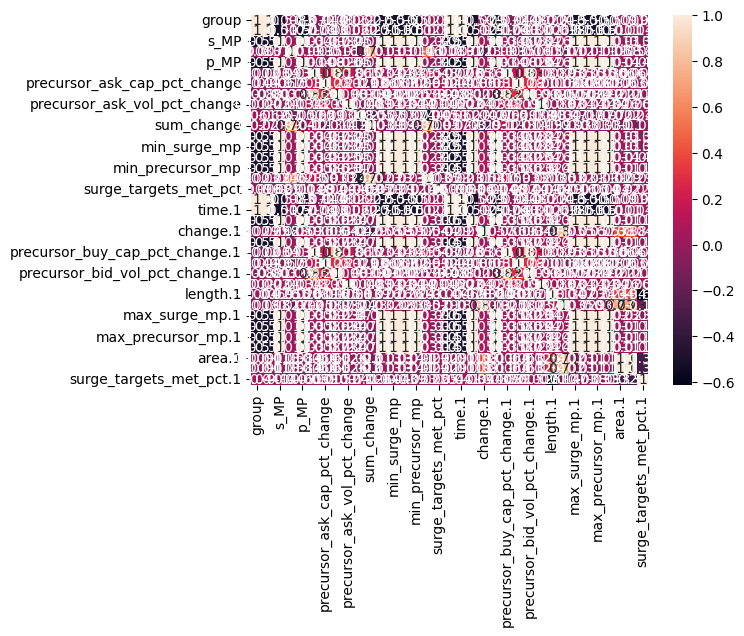

In [5]:
import pandas as pd
import seaborn as sns

# Load the dataset into a pandas dataframe

# Calculate the correlation matrix
corr_matrix = m2_pipeline.corr(numeric_only=True)

# Plot the correlation matrix
sns.heatmap(corr_matrix, annot=True)


XGB, GBM, CAT, FASTAI, NN_TORCH, LR, RF, XT

In [6]:
m2_pipeline.dtypes

group                               int64
time                              float64
s_MP                              float64
change                            float64
type                               object
p_MP                              float64
precursor_buy_cap_pct_change      float64
precursor_ask_cap_pct_change      float64
precursor_bid_vol_pct_change      float64
precursor_ask_vol_pct_change      float64
length                              int64
sum_change                        float64
max_surge_mp                      float64
min_surge_mp                      float64
max_precursor_mp                  float64
min_precursor_mp                  float64
area                              float64
surge_targets_met_pct             float64
group.1                             int64
time.1                            float64
s_MP.1                            float64
change.1                          float64
type.1                             object
p_MP.1                            

### utilize the same feature composition as used in step 2

clustering setup, per 'step 2'

set m2_pipeline features to the set, below to do a classifier search

In [7]:
keepable = ['precursor_buy_cap_pct_change', 
            'precursor_ask_cap_pct_change',
            'precursor_bid_vol_pct_change', 
            'precursor_ask_vol_pct_change',
            'sum_change','length','time']

In [11]:

# Splitting the dataframe into features and labels
# X = m2_pipeline.drop(columns=['label'])
y = m2_pipeline['surge_targets_met_pct'].values #per https://stackoverflow.com/a/73095562/12001832
X = m2_pipeline[keepable].values
# Performing the test/train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#normalize all numeric columns
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
# Define the classifiers and their respective hyperparameters
classifiers = [
    DecisionTreeRegressor(),
    RidgeCV(),
    LassoCV()
]

params = {
    'DecisionTreeRegressor':{'max_depth':[2,3,4,5,6,7,8], 'splitter':['best','random'],'criterion':['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],\
        'random_state':[42]},                                                                                       
    'RidgeCV':{'alphas':[0.1, 1.0, 10.0]},
    'LassoCV':{ 'eps':[0.001, 0.01, .1], 'n_alphas':[100,200],  'max_iter':[100,200,300,1000]},
}
comparative = []
# Perform the grid search
for clf in classifiers:
    name = clf.__class__.__name__
    if name in params:
        grid_search = GridSearchCV(clf, params[name], cv=5)
        grid_search.fit(X_train_scaled, y_train)
        
        print(f"Best parameters for {name}: {grid_search.best_params_}")
        accuracy = grid_search.score(X_test, y_test)
        
        dict = {"classifier":name, "best_params":grid_search.best_params_, "accuracy":accuracy}
        comparative.append(dict)
dg = pd.DataFrame(comparative) #display grid


70 fits failed out of a total of 280.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
70 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/stefanbund/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/stefanbund/Library/Python/3.9/lib/python/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/stefanbund/Library/Python/3.9/lib/python/site-packages/sklearn/tree/_classes.py", line 1320, in fit
    super()._fit(
  File "/Users/stefanbund/Library/Python/3.9/lib/python/site-packages/sklearn/tree/_classes.py", line 

Best parameters for DecisionTreeRegressor: {'criterion': 'absolute_error', 'max_depth': 4, 'random_state': 42, 'splitter': 'best'}
Best parameters for RidgeCV: {'alphas': 10.0}
Best parameters for LassoCV: {'eps': 0.1, 'max_iter': 100, 'n_alphas': 100}


In [13]:
dg

,classifier,best_params,accuracy
0,DecisionTreeRegressor,"{'criterion': 'absolute_error', 'max_depth': 4...",-1.832669e-01
1,RidgeCV,{'alphas': 10.0},-8.174875e+20
2,LassoCV,"{'eps': 0.1, 'max_iter': 100, 'n_alphas': 100}",-8.674037e-04


In [30]:
dg[dg['classifier']=='DecisionTreeRegressor']['best_params']

0    {'criterion': 'absolute_error', 'max_depth': 4...
Name: best_params, dtype: object

In [52]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

# X = m2_pipeline[keepable].values  #.drop(columns=['label']).values #per https://stackoverflow.com/a/73095562/12001832
# y = m2_pipeline['surge_targets_met_pct'].values
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# #normalize all numeric columns
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)

dtr = DecisionTreeRegressor(criterion='absolute_error', max_depth=4, random_state=42,splitter='best')
dtr.fit(X_train_scaled, y_train)
# y_pred = dtr.predict(X_test)
# f1_score(y_test, y_pred,average='weighted')

scores = cross_val_score(dtr, X_test, y_test,  cv=5, scoring='r2')
print(scores.mean())
# print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std()))

-0.0005616036366595356


In [20]:


# dtr = DecisionTreeRegressor(criterion='absolute_error', max_depth=4, random_state=42)
# rcv = RidgeCV(alphas=10.0)
# lcv = LassoCV(eps=0.1, max_iter=100, n_alphas=100)

## Voting Classifier

In [23]:
# import shap #this library would take 30 hours to explain the above model, not to be used. would function on one tree, better
# from sklearn.ensemble import  VotingClassifier 
# from sklearn.model_selection import cross_val_score
# X = m2_pipeline[keepable].values  #.drop(columns=['label']).values #per https://stackoverflow.com/a/73095562/12001832
# y = m2_pipeline['surge_targets_met_pct'].values
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# #normalize all numeric columns
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)

# # Define VotingClassifier 
# weights = [0.1, 0.5, 0.1, 0.1, 0.2]
# vc = VotingClassifier(estimators=[('dtr',dtr),('rcv',rcv),('lcv',lcv)], voting='hard', weights=weights) 
# dtr.fit(X_train_scaled,y_train)
# rcv.fit(X_train_scaled,y_train)
# lcv.fit(X_train_scaled,y_train)

# # #fit all, voting classifier scoring
# for clf, label in zip([dtr,rcv,vc], ['DecisionTreeRegressor','RidgeCV','Voting']):
#     scores = cross_val_score(clf, X_train_scaled, y_train, scoring='accuracy', cv=5)
#     print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

### feature importance based on feature permutation
[via scikit learn's rendition](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#feature-importance-based-on-feature-permutation)

In [24]:
# feature_names = [f"feature {i}" for i in range(X.shape[1])]

# print(m2_pipeline.columns,X.shape[1])
# for i in range(len(treeGroup)):
#     print(treeGroup[i]) #tree to study
#     forest = treeGroup[i]
#     start_time = time.time()
#     result = permutation_importance(forest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
#     elapsed_time = time.time() - start_time
#     print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

#     forest_importances = pd.Series(result.importances_mean, index=feature_names)
#     fig, ax = plt.subplots()
#     forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
#     ax.set_title("Feature importances using permutation on full model")
#     ax.set_ylabel("Mean accuracy decrease")
#     fig.tight_layout()
#     print(treeGroup[i]) #tree to study

#     plt.show()

## Error Analysis

confusion matrix for multiclass predict vs true results. [source](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.multilabel_confusion_matrix.html)

In [28]:
labels_ = m2_pipeline['surge_targets_met_pct']
print(labels_)

0      -0.066689
1       0.100536
2      -0.066845
3       0.234663
4      -0.066845
          ...   
5821    0.099900
5822    0.099800
5823    0.000000
5824    0.000000
5825    0.000000
Name: surge_targets_met_pct, Length: 5826, dtype: float64


## voting classifier error analysis

In [29]:
X_test_scaled = scaler.fit_transform(X_test)
y_pred = dtr.predict(X_test_scaled)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, labels=labels_)

ValueError: continuous is not supported

error report courtesty of sklearn's [classification report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn-metrics-classification-report)

In [146]:
print(classification_report(y_test, y_pred,zero_division=1))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00        22
           3       0.14      0.05      0.07        78
           4       0.44      0.58      0.50       511
           5       0.30      0.34      0.32       231
           6       0.20      0.04      0.07       139
           7       0.18      0.05      0.07       128
           8       0.00      0.00      0.00        34
           9       0.00      0.00      0.00         7
          10       0.08      0.22      0.12         9
          11       1.00      0.00      0.00         3

    accuracy                           0.33      1166
   macro avg       0.21      0.12      0.11      1166
weighted avg       0.31      0.33      0.30      1166



uncertainty in prediction, per class basis, [per sklearn](https://scikit-learn.org/stable/auto_examples/semi_supervised/plot_label_propagation_digits.html#plot-the-most-uncertain-predictions)

## SHAP feature analysis

[source](https://github.com/shap/shap)

In [148]:
keepable = ['precursor_buy_cap_pct_change', 
            'precursor_ask_cap_pct_change',
            'precursor_bid_vol_pct_change', 
            'precursor_ask_vol_pct_change',
            'sum_change',
            'length','time']

### Random Forest Classifier Feature Strength

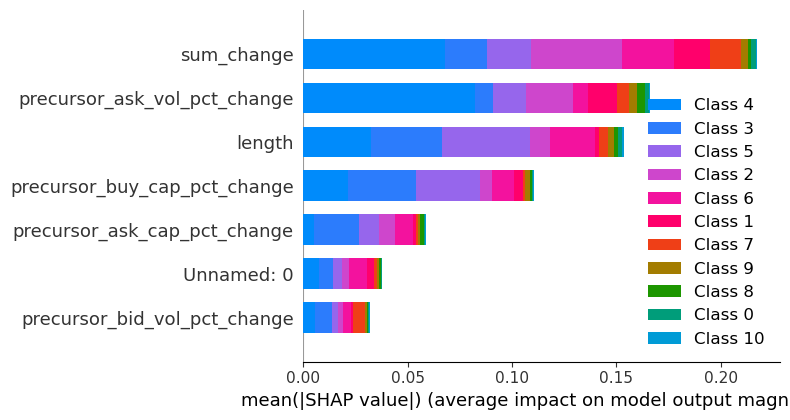

In [149]:
# estimators = [rfc,gbc,hgbc,etc,bc,vc]
model = rfc.fit(X_train_scaled,y_train)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, features=m2_pipeline.columns)

### HGBC SHAP

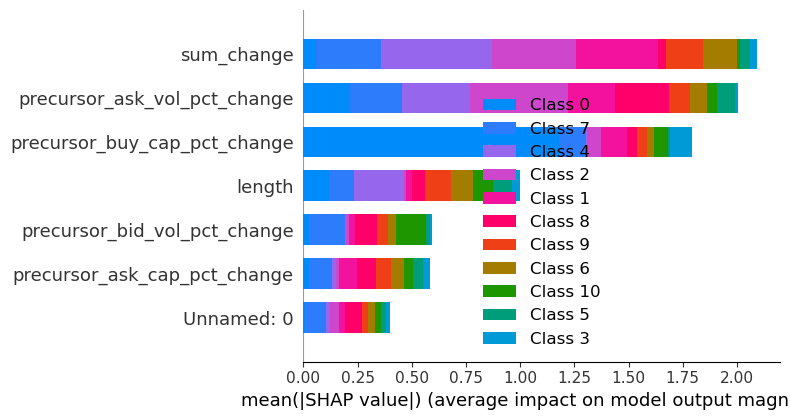

In [150]:
# estimators = [rfc,gbc,hgbc,etc,bc,vc]
model = hgbc.fit(X_train_scaled,y_train)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, features=m2_pipeline.columns)

### Extra Trees Classifier SHAP

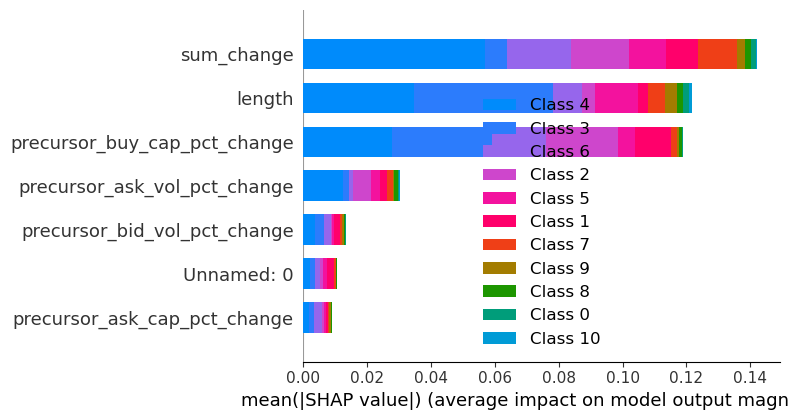

In [152]:
# estimators = [rfc,gbc,hgbc,etc,bc,vc]
model = etc.fit(X_train_scaled,y_train)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, features=m2_pipeline.columns)

## 


### How do multiple classifiers collectively make good choices?

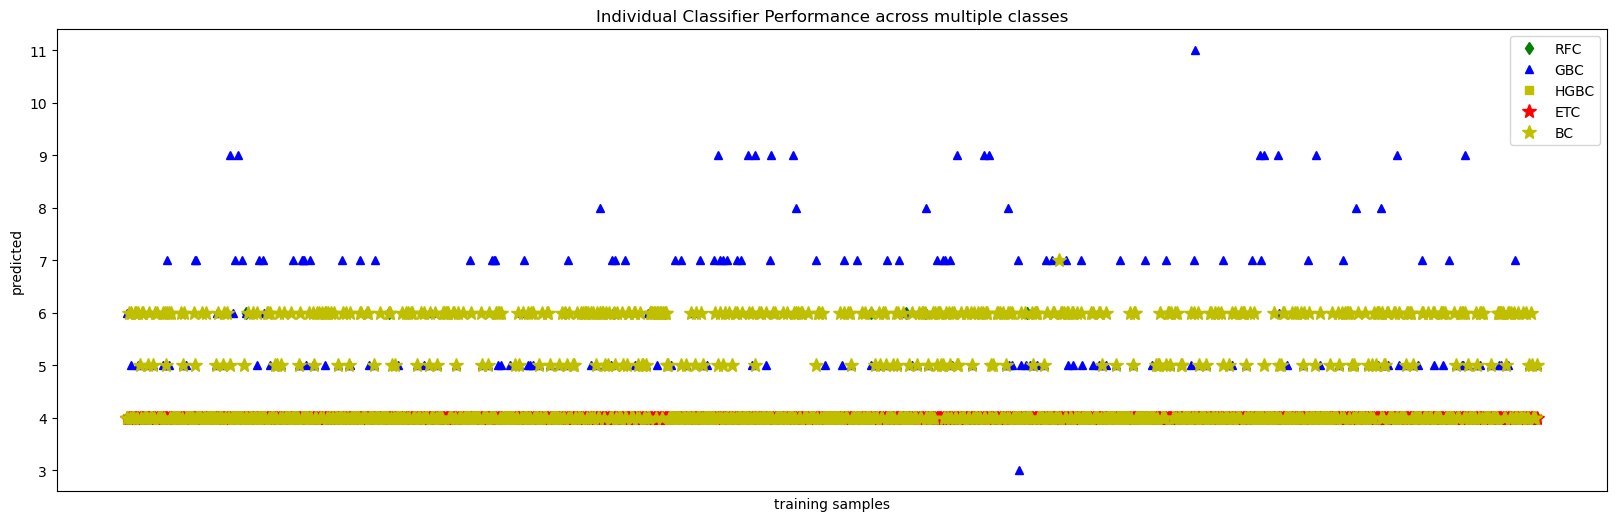

In [153]:
xt = X_test#  train_scaled[:300]

pred1 = rfc.predict(xt)
pred2 = gbc.predict(xt)
pred3 = hgbc.predict(xt)

pred4 = etc.predict(xt)
pred5 = bc.predict(xt)
pred6 = vc.predict(xt)

plt.figure(figsize=(20,6))
plt.plot(pred1, "gd", label="RFC")
plt.plot(pred2, "b^", label="GBC")
plt.plot(pred3, "ys", label="HGBC")
plt.plot(pred4, "r*", ms=10, label="ETC")
plt.plot(pred5, "y*", ms=10, label="BC")
# plt.plot(pred6, "g*", ms=10, label="VOTE")
plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.ylabel("predicted")
plt.xlabel("training samples")
plt.legend(loc="best")
plt.title("Individual Classifier Performance across multiple classes")
# ax.annotate('race interrupted', (61, 25),
#             xytext=(0.8, 0.9), textcoords='axes fraction',
#             arrowprops=dict(facecolor='black', shrink=0.05),
#             fontsize=16,
#             horizontalalignment='right', verticalalignment='top')
plt.show()


### Can the voting classifier locate optimal trades among a sea of lesser options?

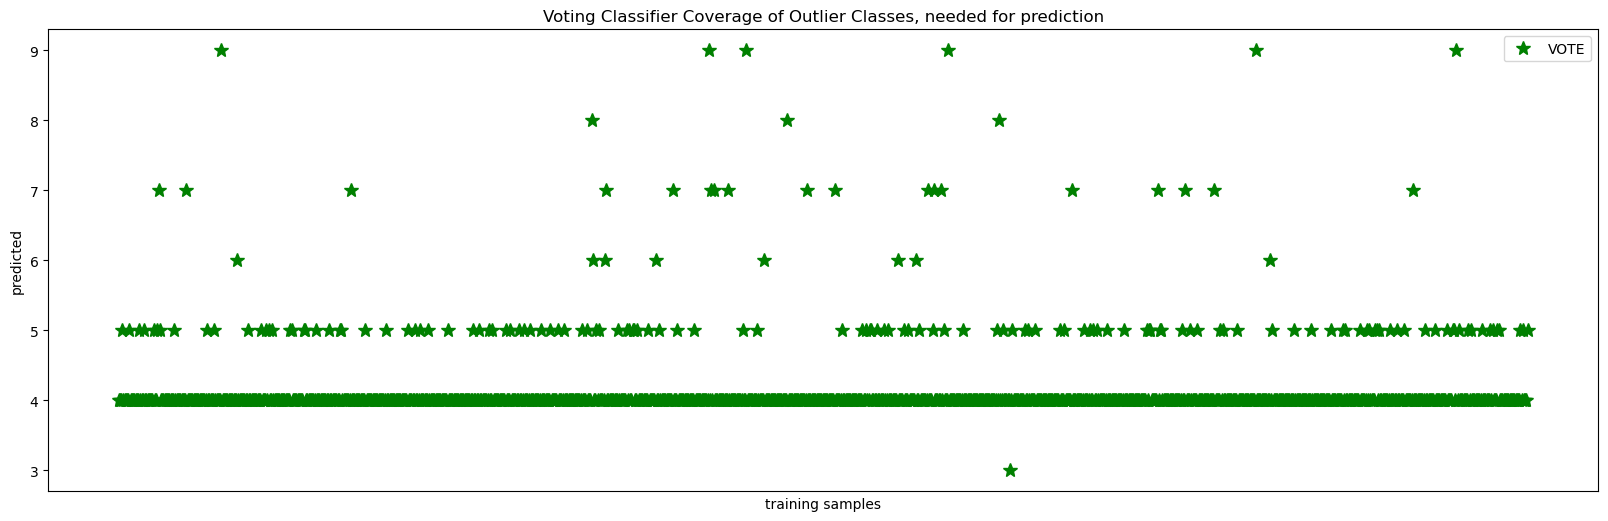

In [154]:
plt.figure(figsize=(20,6))
plt.plot(pred6, "g*", ms=10, label="VOTE")
plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.ylabel("predicted")
plt.xlabel("training samples")
plt.legend(loc="best")
plt.title("Voting Classifier Coverage of Outlier Classes, needed for prediction")
plt.show()

### GBC ability to identify outlier, profitable classes

              precision    recall  f1-score   support

           1       1.00      0.00      0.00         4
           2       1.00      0.00      0.00        22
           3       0.00      0.00      0.00        78
           4       0.45      0.81      0.58       511
           5       0.29      0.18      0.22       231
           6       0.06      0.01      0.01       139
           7       0.17      0.08      0.11       128
           8       0.17      0.03      0.05        34
           9       0.00      0.00      0.00         7
          10       1.00      0.00      0.00         9
          11       0.00      0.00      0.00         3

    accuracy                           0.40      1166
   macro avg       0.37      0.10      0.09      1166
weighted avg       0.31      0.40      0.31      1166



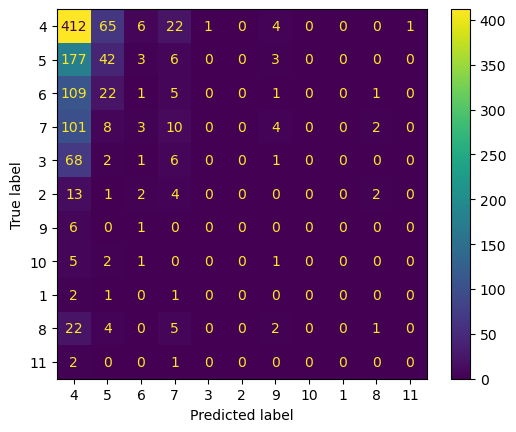

In [155]:
# X_test_scaled = scaler.fit_transform(X_test)
y_pred_gbc = gbc.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_gbc, labels=labels_)

print(classification_report(y_test, y_pred_gbc,zero_division=1))


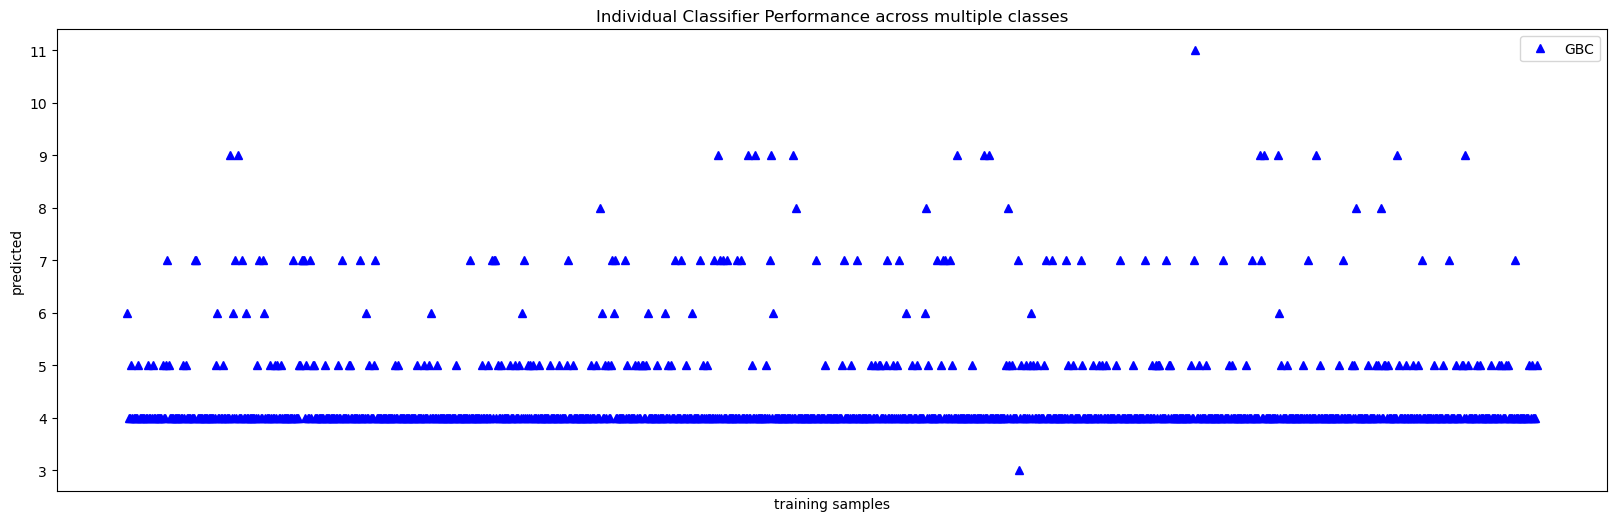

In [156]:
plt.figure(figsize=(20,6))
plt.plot(pred2, "b^", label="GBC")

# plt.plot(pred6, "g*", ms=10, label="VOTE")
plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.ylabel("predicted")
plt.xlabel("training samples")
plt.legend(loc="best")
plt.title("Individual Classifier Performance across multiple classes")
plt.show()


## create a time series from predicted values

In [157]:



# Predict labels for your test data
y_pred = gbc.predict(X_test)

X_test_df = pd.DataFrame(X_test)

# Concatenate the predicted labels with X_test_df
result = pd.concat([X_test_df, pd.Series(y_pred, name='predicted_label')], axis=1)

In [190]:
result['predicted_label'].value_counts()

4     917
5     147
7      60
6      18
9      16
8       6
11      1
3       1
Name: predicted_label, dtype: int64

In [171]:
print('\n'.join([f'{i}: {value}' for i, value in enumerate(keepable)]))

0: precursor_buy_cap_pct_change
1: precursor_ask_cap_pct_change
2: precursor_bid_vol_pct_change
3: precursor_ask_vol_pct_change
4: sum_change
5: length
6: time


In [173]:
result.dtypes

0                  float64
1                  float64
2                  float64
3                  float64
4                  float64
5                  float64
6                  float64
predicted_label      int64
dtype: object

In [177]:
# sns.pairplot(result, hue='predicted_label', height=1.5)
result = result.sort_values(by=6)

In [195]:
keepable = ['precursor_buy_cap_pct_change', 'precursor_ask_cap_pct_change',
            'precursor_bid_vol_pct_change', 'precursor_ask_vol_pct_change',
            'sum_change', 'length', 'time','predicted_label']

result = result.rename(columns={i: keepable[i] for i in range(7)})

In [197]:
result

,precursor_buy_cap_pct_change,precursor_ask_cap_pct_change,precursor_bid_vol_pct_change,precursor_ask_vol_pct_change,sum_change,length,surge_targets_met_pct,predicted_label
332,-0.008301,0.000101,-0.001793,0.015760,-0.008805,3.0,1.660232e+12,4
1093,0.251821,0.002041,0.076246,0.360129,-0.002041,1.0,1.660249e+12,7
234,-0.072644,0.000178,-0.022135,0.032534,-0.022106,4.0,1.660257e+12,4
301,0.066227,0.001243,0.022618,0.185320,-0.000311,1.0,1.660269e+12,7
952,-0.196120,-0.002084,-0.067795,-0.263773,-0.005565,2.0,1.660284e+12,6
...,...,...,...,...,...,...,...,...
1130,0.004096,0.000166,0.000969,0.000788,-0.000501,1.0,1.692974e+12,4
405,-0.003737,0.003281,-0.000869,0.016512,-0.005082,5.0,1.692990e+12,4
828,0.000449,-0.000605,0.000022,-0.003029,-0.000696,1.0,1.693045e+12,4
76,-0.008630,-0.000898,-0.002323,-0.003895,-0.001692,2.0,1.693064e+12,4


In [198]:
gds = pd.read_csv('global_data.csv')

In [199]:
# make a dataframe by joining gds on result, by time

# chart mp to time as a line  


# chart vertical lines for time and predicted_label


## why does GBC confuse class 10 as class 4?

In [77]:
m2_pipeline.columns

Index(['Unnamed: 0', 'precursor_buy_cap_pct_change',
       'precursor_ask_cap_pct_change', 'precursor_bid_vol_pct_change',
       'precursor_ask_vol_pct_change', 'sum_change', 'length',
       'surge_targets_met_pct', 'label'],
      dtype='object')

In [78]:
m2_pipeline.dtypes

Unnamed: 0                        int64
precursor_buy_cap_pct_change    float64
precursor_ask_cap_pct_change    float64
precursor_bid_vol_pct_change    float64
precursor_ask_vol_pct_change    float64
sum_change                      float64
length                            int64
surge_targets_met_pct           float64
label                             int64
dtype: object

In [87]:
# m2_pipeline[m2_pipeline['label'] == 4]

In [88]:
# Select rows with label equal to 4 or 10
# rows = m2_pipeline[(m2_pipeline['label'] == 4) | (m2_pipeline['label'] == 10)]
labeled = ['precursor_buy_cap_pct_change', 
            'precursor_ask_cap_pct_change',
            'precursor_bid_vol_pct_change', 
            'precursor_ask_vol_pct_change',
            'sum_change','length', 'label']
import pandas as pd
import matplotlib.pyplot as plt
subset = m2_pipeline[labeled]
subset.columns

Index(['precursor_buy_cap_pct_change', 'precursor_ask_cap_pct_change',
       'precursor_bid_vol_pct_change', 'precursor_ask_vol_pct_change',
       'sum_change', 'length', 'label'],
      dtype='object')

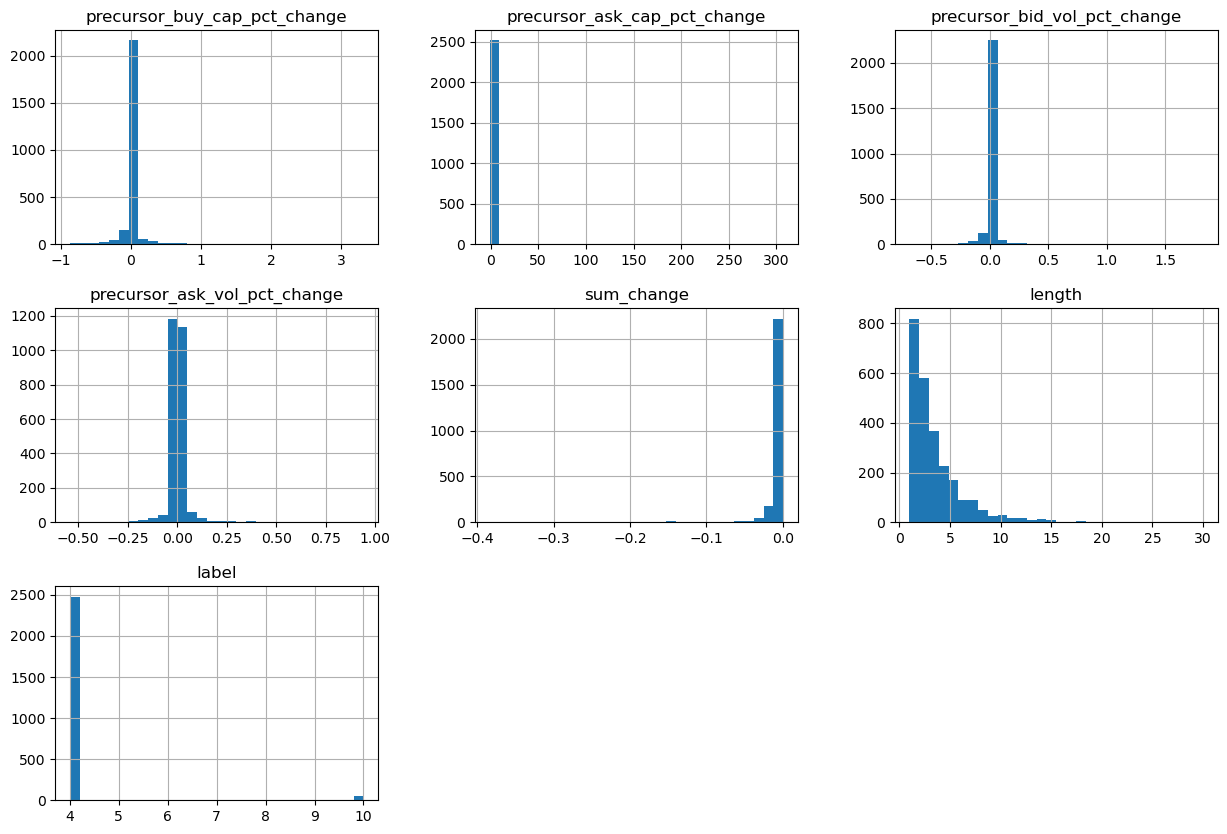

In [95]:
# Select rows with label equal to 4 or 10
rows = subset[(subset['label'] == 4) | (subset['label'] == 10)]

# Create histograms for all columns in the selected rows
rows.hist(bins=30, figsize=(15, 10))

# Show the histograms
plt.show()

In [96]:
subset[(subset['label'] == 4)]['sum_change'].mean()

-0.008453832723064823

In [97]:
subset[(subset['label'] == 10)]['sum_change'].mean()

-0.03706188073835746

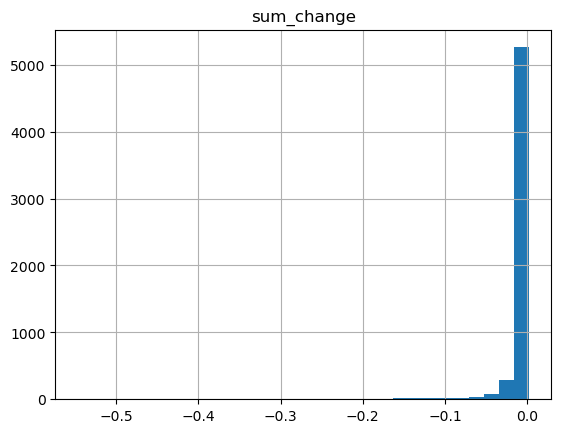

In [98]:
# Create a histogram for the 'sum_change' column
subset.hist(column='sum_change', bins=30)

# Show the histogram
plt.show()

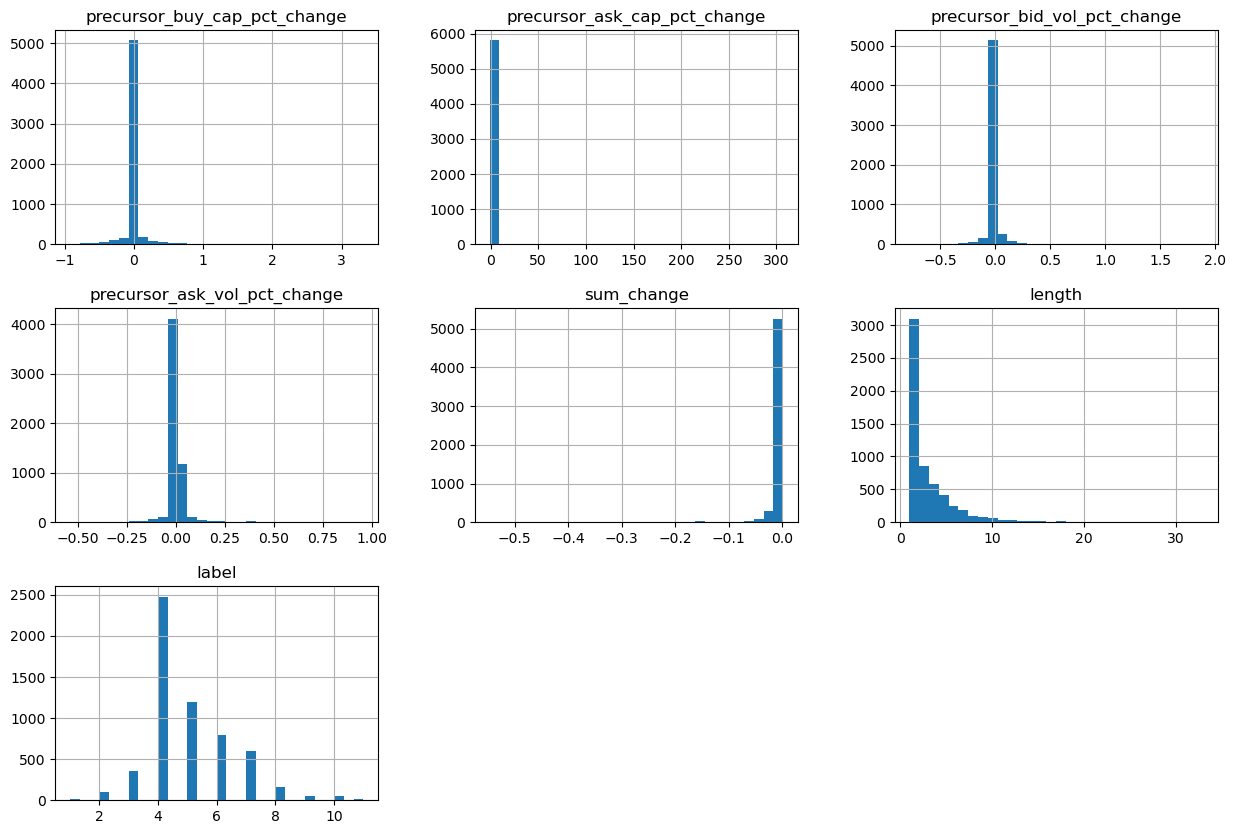

In [99]:
subset.hist(bins=30, figsize=(15, 10))

# Show the histograms
plt.show()

### distribution of features, class 10

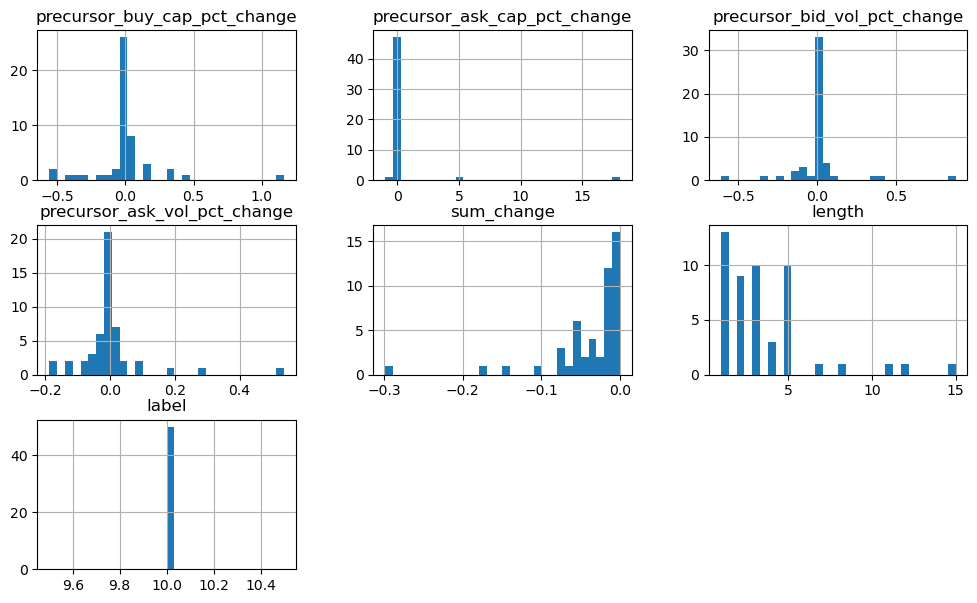

In [111]:
subset[(subset['label'] == 10)].hist(bins=30, figsize=(12, 7))
plt.show()

### feature distribution, class 4

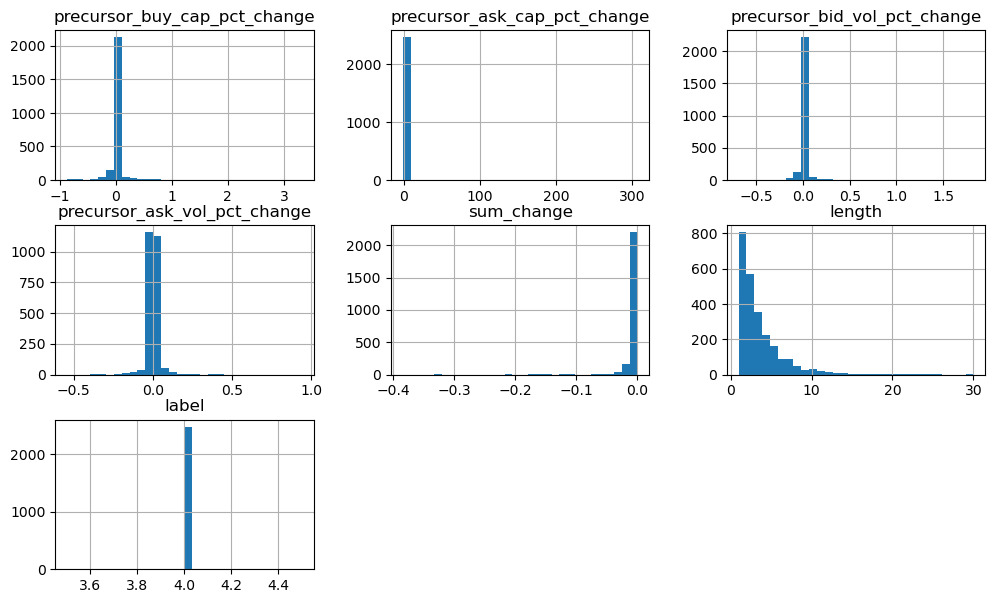

In [112]:
subset[(subset['label'] == 4)].hist(bins=30, figsize=(12, 7))
plt.show()

## Permutation test scoring

[from sklearn](https://scikit-learn.org/stable/auto_examples/model_selection/plot_permutation_tests_for_classification.html#permutation-test-score)

## managing class imbalance

(https://stackoverflow.com/a/55591245)

see next sheet, 5.1


In [ ]:
#save this thing to .pkl format

# import pickle

# with open("model.pkl", "wb") as f:
#     pickle.dump(vc, f)